# On cherche à trouver le meilleur plan d'expérience

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Nous considérons un vecteur de $8$ fonctions $X = (f_1, f_2, \dots, f_8)$
où chaque fonction $f_i$ est définie sur l'intervalle temporel $[0,T]$ et prend ses valeurs dans $[-1,5]$.  
Ces fonctions modélisent des signaux périodiques et aléatoires, construits à l'aide d'une décomposition de Fourier tronquée.

Pour chaque paramètre $\alpha_i \in [0.5,3]$, nous générons une fonction $f_i$ à partir d'une série de Fourier complexe de la forme
$f_i(t)= 2 + A \sum_{k=0}^{N-1} a_{i,k}\,(1+k^2)^{\alpha_i}\, e^{\, i \,\omega_{i}\, k\, t},\qquad t \in [0,T].
$

Dans cette expression :  
    - $N$ est le nombre de modes de Fourier conservés ;  
    - les coefficients aléatoires $a_{i,k}$ sont tirés uniformément dans $[-1,1]$ ;  
    - le terme $(1+k^2)^{\alpha_i}$ impose une décroissance contrôlée de l'amplitude des hautes fréquences ;  
    - $\omega_i$ est une pulsation aléatoire, choisie uniformément dans l'intervalle $\left[\frac{2\pi}{T_{\min}}, \frac{2\pi}{T_{\max}}\right]$ ;  
    - $A=2$ est une amplitude globale permettant de centrer les signaux dans l'intervalle $[-1,5]$ après ajout d'un biais constant ;  
    - nous ne conservons finalement que la partie réelle de la série afin d'obtenir un signal réel.  

Ainsi, pour chaque valeur de $\alpha_i$, nous obtenons une fonction périodique dont la régularité dépend directement du paramètre $\alpha_i$ :  
plus $\alpha_i$ est grand, plus la décroissance des coefficients de Fourier est rapide, et plus la fonction générée est régulière.

In [16]:
T=36                  # On regarde toutes les 10 minutes pendant 6 heures
t=np.linspace(1,T,T)    # t=[1,2,...,36]

alphas=np.sort(np.random.uniform(0.5,3,8))
print("alphas=",alphas)

def Simulation_aléatoire(alphas):
    params = []  # stockera les paramètres figés
    N_fourier = 20
    for alpha in alphas:
        a = np.random.uniform(-1, 1, N_fourier)
        k = np.arange(N_fourier)
        decay = 1.0 / (1 + k**2)**alpha
        phase = 2 * np.pi / np.random.uniform(0,T)
        amplitude = 2
        params.append((a, k, decay, phase, amplitude))

    def make_func(a, k, decay, phase, amplitude):
        return lambda t: 2 + amplitude * np.sum(
            (a * decay)[:, None] * np.exp(1j * phase * k[:, None] * t[None, :]),
            axis=0
        ).real

    return np.array([make_func(*p) for p in params], dtype=object)


alphas= [0.61013334 0.74458233 1.17309806 2.13948936 2.24429825 2.27447325
 2.4462835  2.62011661]


On choisit nos alphas une fois et on ne les change plus

(8,)


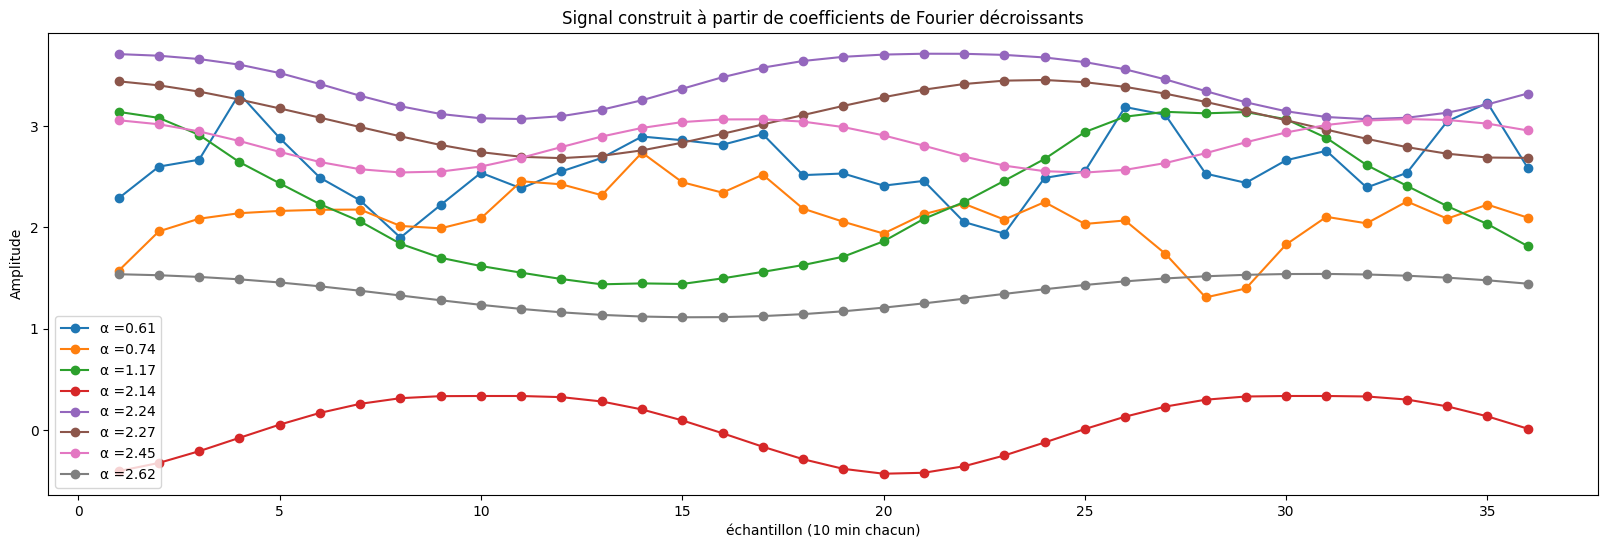

In [17]:
X = Simulation_aléatoire(alphas) # exemple de 8 séries temporelles simulées
print(X.shape)

plt.figure(figsize=(20,6))
for i in range(8):
    plt.plot(t, X[i](t),marker='o',label=f"α ={alphas[i]:.2f}")
plt.xlabel('échantillon (10 min chacun)')
plt.ylabel('Amplitude')
plt.title('Signal construit à partir de coefficients de Fourier décroissants')
plt.legend()
plt.show()

On va avoir besoin de calculer la distance entre 2 entrées. Pour cela on choisit d'utiliser la définition (14) page 9 du papier "Gaussian process metamodeling of functional-input code
for coastal flood hazard assessment" (On le retrouve dans le dossier *Références*).

In [39]:
def dist_L2(X, Y):
    norm=0
    for i in range(8):
        norm += np.linalg.norm(X[i](t) - Y[i](t))
    return np.sqrt(norm)

X1 = Simulation_aléatoire(alphas)
X2 = Simulation_aléatoire(alphas) 
print(dist_L2(X1,X2))
print(dist_L2(X1,X1))


6.539204528579156
0.0


On va créer plusieurs plans d'expérience (N_plans = 1000). Chaque plan est composé de plusieurs entrées (N_entrées = 200).
Chaque entrée est composée de 8 fonctions comme discuté plus tôt.

In [29]:
def plan(N_entrees,alphas):
    return np.array([Simulation_aléatoire(alphas) for _ in range(N_entrees)], dtype=object)

N_entrees = 200
N_plans = 1000

plans  = np.array([plan(N_entrees,alphas) for _ in range(N_plans)], dtype=object)

print(plans.shape)

(1000, 200, 8)


On utilise un algo de minimum classique pour trouver la distance minimum entre les entrées au sein d'un plan:

In [20]:
def dist_min(plan):
    # plan: shape (N_entrées, 8)
    dmin = np.inf
    for i in range(100):
        for j in range(i+1, 100):
            d = dist_L2(plan[i], plan[j])
            dmin = min(dmin, d)
    return dmin

Et on trouve le plan qui maximise la distance minimum entre les points.

In [21]:
mins = np.array([dist_min(p) for p in plans])
best_index = np.argmax(mins)
best_plan = plans[best_index]

On évalue nos fonctions pour les stocker en dur dans un fichier, python ne peut pas stocker les fonctions directement d'apres ChatGPT.

In [40]:
best_plan_values = np.zeros((N_entrees, 8, T))

for i in range(N_entrees):
    for j in range(8):
        best_plan_values[i, j, :] = best_plan[i, j](t)  # évaluation de la fonction

np.save("./data/best_plan_values.npy", best_plan_values)
